In [1]:
%load_ext autoreload
%autoreload 2

import torch
from dataset import lm2flat_index
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
sns.set()

In [2]:
from typing import List, Tuple
from dataset import OctantDataset
from torch.utils.data import DataLoader
from pytorch3d.structures import Pointclouds
import torch.utils.data as data

ds_nss = OctantDataset("../datasets/neuschwanstein_2000_32max_sh",sub_sample=10000)
ds_simple = OctantDataset("../datasets/datasets/simple_32_sh",sub_sample=10000)

def collate_batched_point_clouds(batch: List[Tuple[Pointclouds, torch.Tensor]]):
    coefs = torch.stack([x[1] for x in batch])
    pcs = Pointclouds(
        points=[x[0].points_packed() for x in batch],
        features=[x[0].features_packed() for x in batch],
    )
    return (pcs, coefs)

batch_size = 256

dataloader_nss = DataLoader(
    ds_nss, batch_size=batch_size, shuffle=True, collate_fn=collate_batched_point_clouds, drop_last=False,num_workers=12, pin_memory=True
)
dataloader_simple = DataLoader(
    ds_simple, batch_size=batch_size, shuffle=True, collate_fn=collate_batched_point_clouds, drop_last=False,num_workers=12, pin_memory=True
)

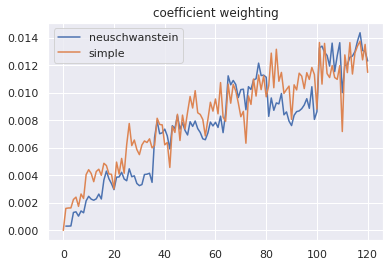

In [3]:
l = 10

coefs = torch.stack([ds_nss[i][1][ : lm2flat_index(l, -l) + 1] for i in np.random.choice(len(ds_nss),1000)])
avg_coefs = coefs.abs().permute(1,0,2).flatten(1).mean(1)

weighting_nss = 1/avg_coefs
weighting_nss /= weighting_nss.sum() 


coefs = torch.stack([ds_simple[i][1][ : lm2flat_index(l, -l) + 1] for i in np.random.choice(len(ds_simple),1000)])
avg_coefs = coefs.abs().permute(1,0,2).flatten(1).mean(1)

weighting_simple = 1/avg_coefs
weighting_simple /= weighting_simple.sum() 


plt.plot(torch.arange(1,len(weighting_nss)),weighting_nss[1:],label="neuschwanstein")

plt.plot(weighting_simple,label="simple")
plt.title("coefficient weighting")
plt.legend()

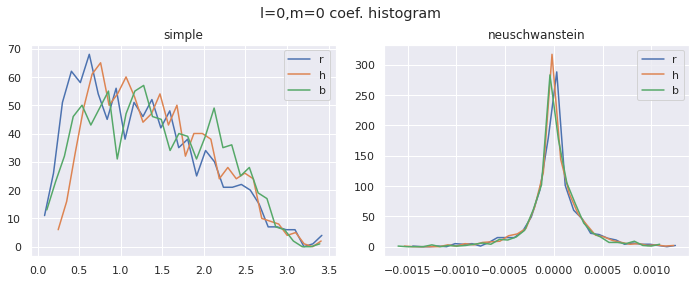

In [4]:
fig,axes = plt.subplots(1,2,figsize=(10,4))

fig.suptitle("l=0,m=0 coef. histogram")
fig.tight_layout()

for row,(name,ds) in enumerate([("simple",ds_simple),("neuschwanstein",ds_nss)]):
    ax = axes[row]
    coefs = torch.stack([ds[i][1][ : lm2flat_index(l, -l) + 1] for i in np.random.choice(len(ds),1000)])
    counts,bins = coefs[:,0,0].histogram(bins=32)
    ax.plot((bins[:-1]+bins[1:])/2,counts,label="r")

    counts,bins = coefs[:,0,1].histogram(bins=32)
    ax.plot((bins[:-1]+bins[1:])/2,counts,label="h")

    counts,bins = coefs[:,0,2].histogram(bins=32)
    ax.plot((bins[:-1]+bins[1:])/2,counts,label="b")
    ax.set_title(name)
    ax.legend()

simple tensor(1.3509)
neuschwanstein tensor(-3.5061e-06)


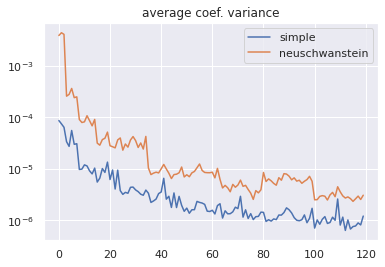

In [5]:
plt.title("average coef. variance")
for row,(name,ds) in enumerate([("simple",ds_simple),("neuschwanstein",ds_nss)]):

    coefs = torch.stack([ds[i][1][ : lm2flat_index(l, -l) + 1] for i in np.random.choice(len(ds),1000)])

    var = coefs.var([0,2])
    mean = coefs.mean([0,2])
    plt.plot(var[1:],label=name)
    # plt.plot(var,label=name)
    print(name,mean[0])

plt.yscale("log")
plt.legend()

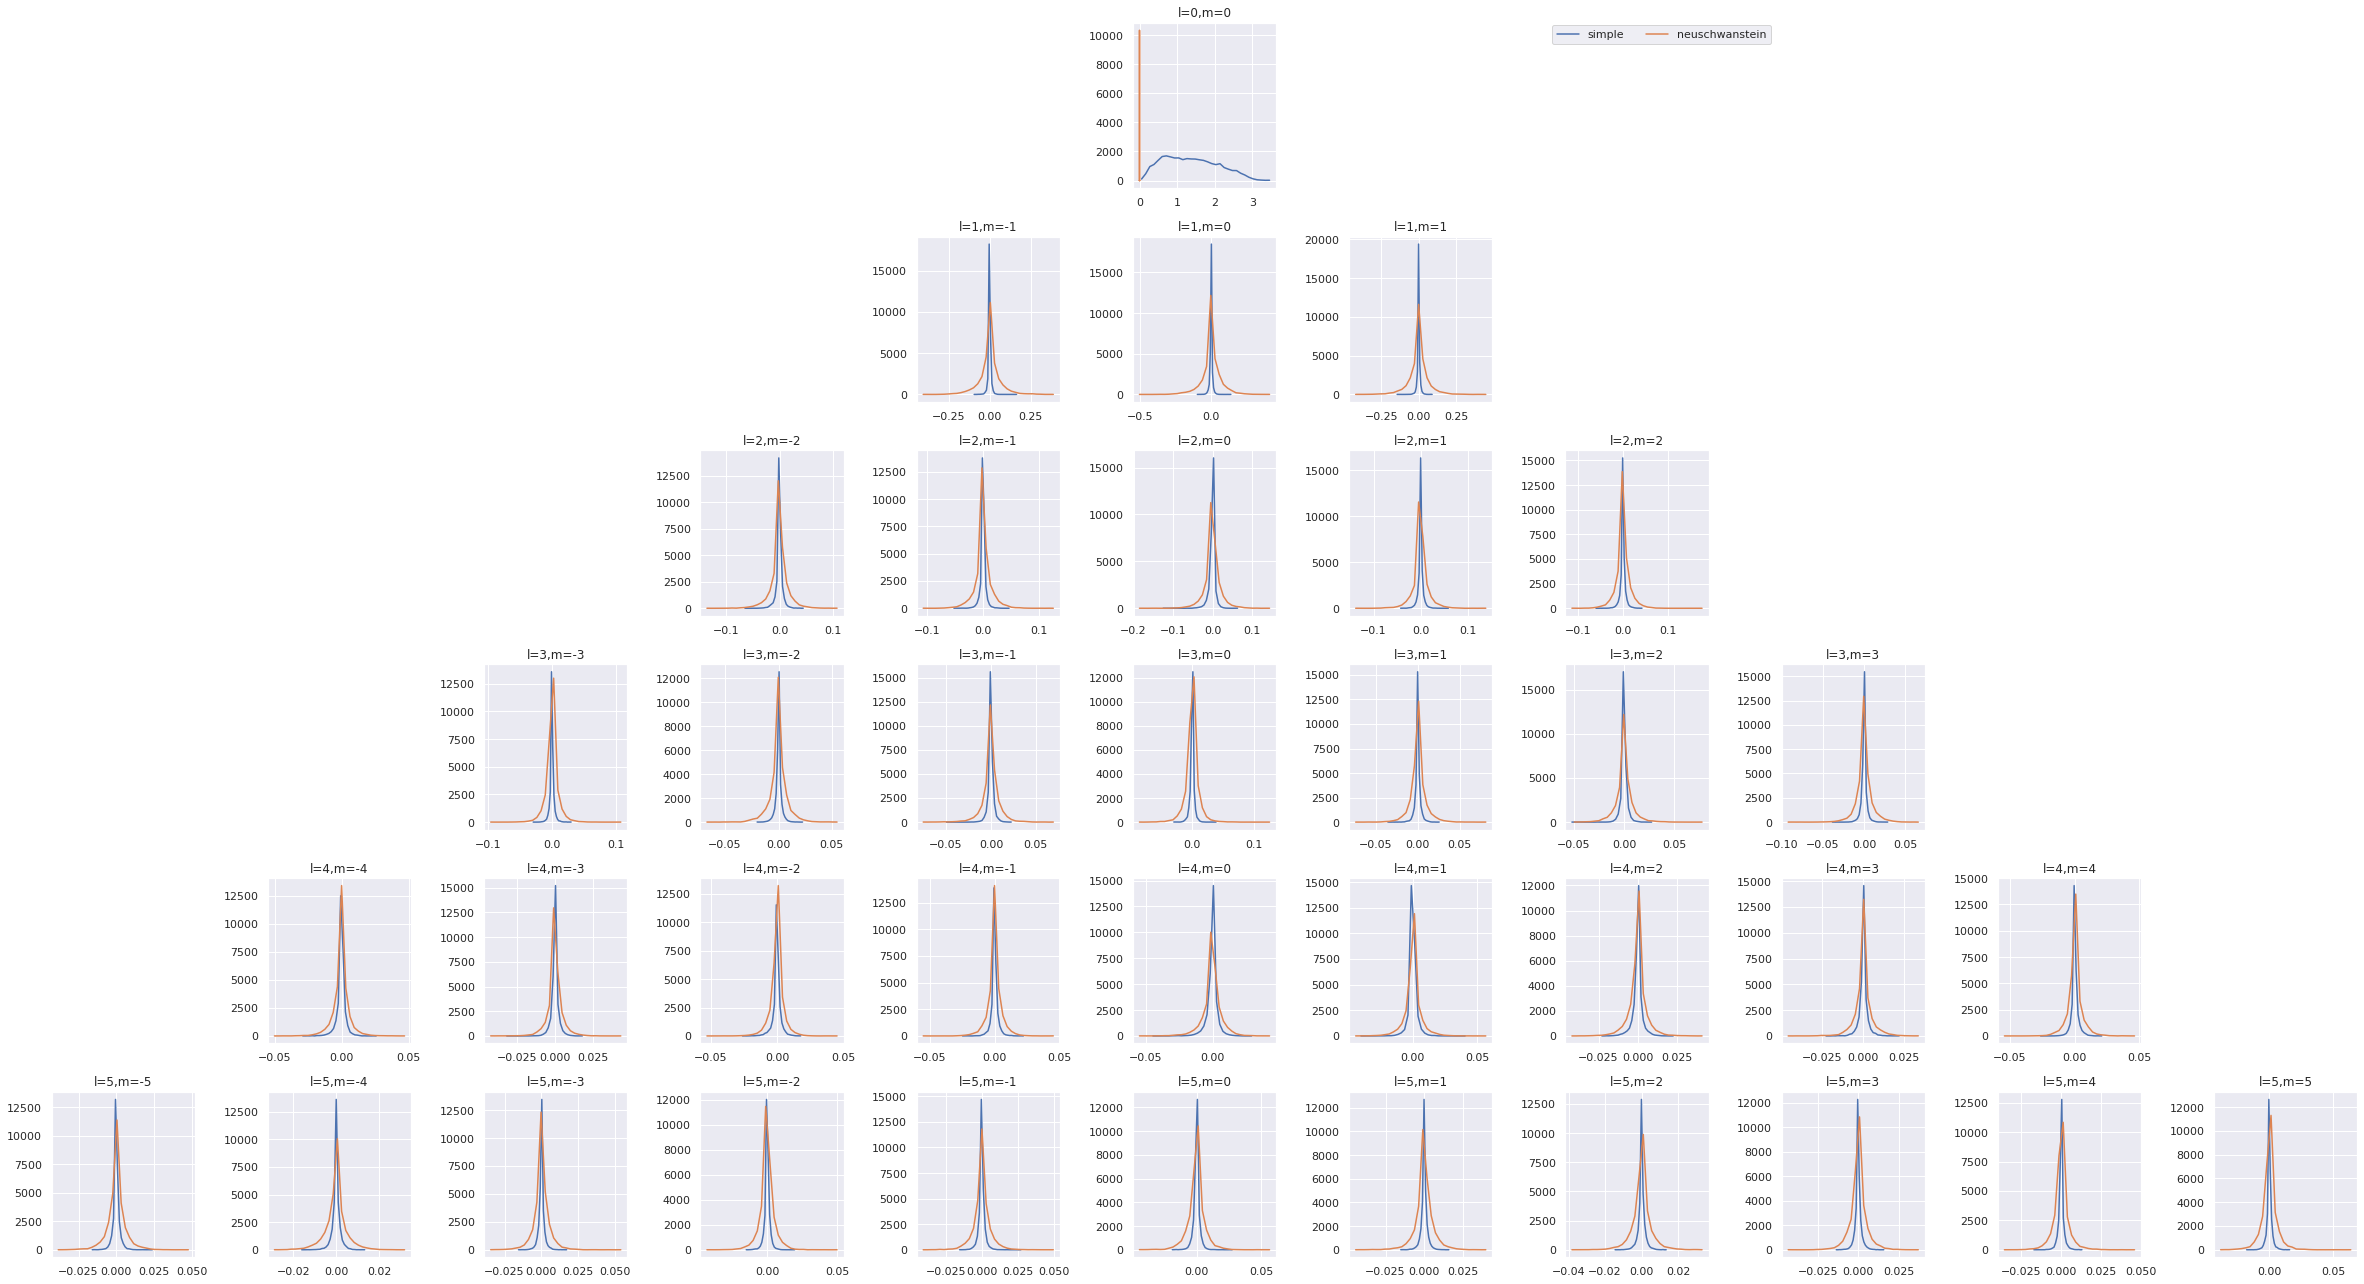

In [6]:

coefs_simple = torch.stack([c for _,c in ds_simple])
coefs_nss = torch.stack([c for _,c in ds_nss])

l_max = 5
fig,axes = plt.subplots(l_max+1,l_max*2+1,figsize=((l_max*2+1)*3,(l_max+1)*3))


for i in range(l_max+1):
    for j in range(l_max*2+1):
        axes[i][j].set_axis_off()


for l_i in range(l_max+1):
    for m in range(-l_i,l_i+1):
        ax = axes[l_i][l_max+m]
        ax.set_title(f"l={l_i},m={m}")
        for row,(name,coefs) in enumerate([("simple",coefs_simple),("neuschwanstein",coefs_nss)]):

            coefs_i = coefs[:,lm2flat_index(l_i,m)]
            # coefs_n = (coefs_i - coefs_i.min())/(coefs_i.max()-coefs_i.min())-0.5
            # coefs_n = (coefs_n-coefs_n.mean())/coefs_n.var()
            # coefs_i = (coefs_i-coefs_i.mean())/coefs_i.std()

            counts,bins = coefs_i.histogram(bins=32)
            ax.plot((bins[:-1]+bins[1:])/2,counts,label=name)
            ax.set_axis_on()
            
# plt.yscale("log")
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', ncol=3, bbox_to_anchor=(.75, 0.98))
plt.tight_layout()

In [ ]:
coefs_simple_n = (coefs_simple[:,0]- coefs_simple[:,0].mean())/coefs_simple[:,0].var()

counts,bins = coefs_simple_n[:,0].histogram(bins=32)
plt.plot((bins[:-1]+bins[1:])/2,counts)

coefs_nss_n = (coefs_nss[:,0]- coefs_nss[:,0].mean())/coefs_nss[:,0].var()

counts,bins = coefs_nss_n[:,0].histogram(bins=32)
plt.plot((bins[:-1]+bins[1:])/2,counts)

In [ ]:
from sh import calc_sh

res = 100
x = torch.arange(0,1,1/res)
grid_x,grid_y = torch.meshgrid(x*torch.pi,x*2*torch.pi,indexing="ij")
coords = torch.stack((grid_x.flatten(),grid_y.flatten())).T

y = calc_sh(l,coords)

pc_simple,a_lm_simple = next(iter(dataloader_simple))
pc_nss,a_lm_nss = next(iter(dataloader_nss))

a_lm_simple = a_lm_simple[:,:lm2flat_index(l, -l) + 1]
a_lm_nss = a_lm_nss[:,:lm2flat_index(l, -l) + 1]

fig,axes = plt.subplots(8,4,figsize=(8,16))

for i in range(8):
    ax1,ax2 = axes[i][:2]
    ax1.set_title("target")
    ax1.set_axis_off()

    target = (y@a_lm_simple[i].cpu()).reshape(res,res,-1).clip(0,1)
    ax1.imshow(target)

    ax2.set_title("avg color")
    ax2.set_axis_off()
    avg =pc_simple.features_list()[i].float().mean(0).reshape(1,1,4) / 255.
    ax2.imshow(avg)

    # second dataset

    ax1,ax2 = axes[i][2:4]

    ax2.set_title("avg color")
    ax2.set_axis_off()
    avg =pc_nss.features_list()[i].float().mean(0).reshape(1,1,4) / 255.
    ax2.imshow(avg)

    ax1.set_title("target")
    ax1.set_axis_off()
    target = (y@a_lm_nss[i].cpu()).reshape(res,res,-1).clip(0,1)
    ax1.imshow(target+avg[:,:,:3])


fig.suptitle("coeffs visualized. left: simple, right: neuschwanstein")

In [ ]:
octant_sizes = [ds_simple[i][0].num_points_per_cloud().item() for i in np.random.choice(len(ds_simple),10000)]
counts,bins = torch.tensor(octant_sizes).float().histogram(bins=16)
plt.plot((bins[:-1]+bins[1:])/2,counts,label="siumple")

octant_sizes = [ds_nss[i][0].num_points_per_cloud().item() for i in np.random.choice(len(ds_nss),10000)]
counts,bins = torch.tensor(octant_sizes).float().histogram(bins=16,)
plt.plot((bins[:-1]+bins[1:])/2,counts,label="neuschwanstein")

x = np.arange(1,32)
plt.plot(x,1350-1200/32*x,"--",label="approx.")

# f(1) = 1400
# f(32) = 200
# 

plt.title("octant sizes histogram")
plt.xlabel("number of points")
plt.legend()
plt.show()

In [ ]:
fig,axes = plt.subplots(2,3,figsize=(10,6))

fig.suptitle("Points distribution in octants (2d histogram)")
fig.tight_layout()

for row,(name,ds) in enumerate([("simple",ds_simple),("neuschwanstein",ds_nss)]):
    all_points = torch.cat([ds[i][0].points_packed() for i in np.random.choice(len(ds),10000)])

    res = 32
    coords = ((all_points + 1)/2 * (res-1)).int()

    ax_names=["x","y","z"]
    for i,(x,y) in enumerate([(0,1),(1,2),(2,0)]):

        pos,count = coords[:,[x,y]].unique(return_counts=True,dim=0)

        heatmap = torch.zeros((res*res),dtype=torch.long)

        heatmap[(pos[:,1]*res+pos[:,0]).long()] = count

        heatmap = heatmap.reshape(res,res)

        # axes[row][i].set_axis_off()
        axes[row][i].set_xlabel(ax_names[x])
        axes[row][i].set_ylabel(ax_names[y])
        axes[row][i].set_xticks([-1,1],[-1,1])
        axes[row][i].set_yticks([-1,1],[-1,1])
        axes[row][i].margins(x=10,y=10)
        axes[row][i].imshow(heatmap)

        if i ==1 :
            axes[row][i].set_title(name)



In [ ]:
fig,axes = plt.subplots(1,2,figsize=(10,4))

fig.suptitle("Points distribution in octants (1d histogram)")
fig.tight_layout()

for col,(name,ds) in enumerate([("simple",ds_simple),("neuschwanstein",ds_nss)]):
    all_points = torch.cat([ds[i][0].points_packed() for i in np.random.choice(len(ds),10000)])

    hist_x = all_points[:,0].histogram(31)
    hist_y = all_points[:,1].histogram(31)
    hist_z = all_points[:,2].histogram(31)


    axes[col].plot(hist_x.bin_edges[:-1],hist_x.hist,label="x")
    axes[col].plot(hist_y.bin_edges[:-1],hist_y.hist,label="y")
    axes[col].plot(hist_z.bin_edges[:-1],hist_z.hist,label="z")


    mean = 0
    var = 0.2

    x = torch.arange(-1,1,2/32)
    # plt.plot(x,4000*1/(var*(2*torch.pi)**0.5)*torch.exp(-0.5*((x-mean)/var).square()))
    axes[col].plot(x,(1-abs(x).sqrt())/(1-abs(x).sqrt()).sum()*len(all_points),"--",label="approximation")
    axes[col].legend()
    axes[col].set_title(name)

In [ ]:
fig,axes = plt.subplots(1,2,figsize=(10,4))

fig.suptitle("Color distribution)")
fig.tight_layout()

for col,(name,ds) in enumerate([("simple",ds_simple),("neuschwanstein",ds_nss)]):

    all_features = torch.cat([ds[i][0].features_packed() for i in np.random.choice(len(ds),10000)])
    hist_r = all_features[:,0].float().histogram(50)
    hist_g = all_features[:,1].float().histogram(50)
    hist_b = all_features[:,2].float().histogram(50)

    ax = axes[col]
    ax.plot(hist_r.bin_edges[:-1],hist_r.hist,label="r")
    ax.plot(hist_g.bin_edges[:-1],hist_g.hist,label="g")
    ax.plot(hist_b.bin_edges[:-1],hist_b.hist,label="b")
    ax.legend()
    ax.set_xlabel("color (0-255)")
    ax.set_title(name)

In [ ]:
fig,axes = plt.subplots(1,2,figsize=(10,4))

fig.suptitle("points varation from octant center)")
fig.tight_layout()

for col,(name,ds) in enumerate([("simple",ds_simple),("neuschwanstein",ds_nss)]):

    coords = torch.stack([ds[i][0].points_packed().var(0) for i in np.random.choice(len(ds),10000) if len(ds[i][0].points_packed())>1])

    hist_x = coords[:,0].histogram(bins=20)
    hist_y = coords[:,1].histogram(bins=20)
    hist_z = coords[:,2].histogram(bins=20)

    ax = axes[col]
    ax.plot(hist_x.bin_edges[:-1],hist_x.hist,label="x")
    ax.plot(hist_y.bin_edges[:-1],hist_y.hist,label="y")
    ax.plot(hist_z.bin_edges[:-1],hist_z.hist,label="z")
    ax.legend()
    ax.set_title(name)

In [ ]:
coords = torch.stack([ds[i][0].points_packed().mean(0) for i in np.random.choice(len(ds),10000) if len(ds[i][0].points_packed())>1])

hist_x = coords[:,0].histogram(bins=20)
hist_y = coords[:,1].histogram(bins=20)
hist_z = coords[:,2].histogram(bins=20)
plt.plot(hist_x.bin_edges[:-1],hist_x.hist,label="x")
plt.plot(hist_y.bin_edges[:-1],hist_y.hist,label="y")
plt.plot(hist_z.bin_edges[:-1],hist_z.hist,label="z")
plt.legend()
plt.title("Octant center (mean)")

In [ ]:
fig,axes = plt.subplots(1,2,figsize=(10,4))

fig.suptitle("Bounding box sizes")
fig.tight_layout()

for col,(name,ds) in enumerate([("simple",ds_simple),("neuschwanstein",ds_nss)]):


    coords = torch.stack([ds[i][0].points_packed().max(dim=0).values-ds[i][0].points_packed().min(dim=0).values for i in np.random.choice(len(ds),10000) if len(ds[i][0].points_packed())>1])

    hist_x = coords[:,0].histogram(bins=20)
    hist_y = coords[:,1].histogram(bins=20)
    hist_z = coords[:,2].histogram(bins=20)
    ax = axes[col]
    ax.plot(hist_x.bin_edges[:-1],hist_x.hist,label="x")
    ax.plot(hist_y.bin_edges[:-1],hist_y.hist,label="y")
    ax.plot(hist_z.bin_edges[:-1],hist_z.hist,label="z")
    ax.legend()
    ax.set_title(name)